# Stationary FFA

This vignette demonstrates how to use the `ffaframework` package to perform flood frequency analysis (model selection, parameter estimation, uncertainty quantification, and model performance assessment) under the assumption of stationarity.

The results are expressed in terms of *return periods* and *return levels*:

- The *return period* of a flood is the expected number of years between annual maximum events of equal or greater magnitude.
- The *return level* is the magnitude of the annual maximum event, measured in $\text{m}^3/\text{s}$.


## Setup

In [1]:
library(ffaframework)

options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 150)
csv_path <- system.file("extdata", "Application_1.csv", package = "ffaframework")
df <- read.csv(csv_path)
df <- subset(df, !is.na(max)) # Remove missing values

head(df)

Loading required package: ggplot2

Loading required package: patchwork



,year,max
,<int>,<dbl>
14,1913,1670
15,1914,3090
16,1915,2760
17,1916,2080
18,1917,2490
19,1918,1470


## Distribution Selection

First, a suitable probability distribution for the data is selected using the L-moments.

1. `select_ldistance` chooses the distribution with theoretical L-skewness ($\tau_3$) and L-kurtosis ($\tau_4$) closest to the sample, based on Euclidean distance.
2. `select_lkurtosis` selects the distribution with the smallest difference between sample and theoretical L-kurtosis (for three-parameter distributions only).
3. `select_zstatistic` uses a fitted 4-parameter Kappa distribution to estimate the sampling distribution of the L-kurtosis and selects the distribution with the smallest z-statistic.

[1] "GEV"


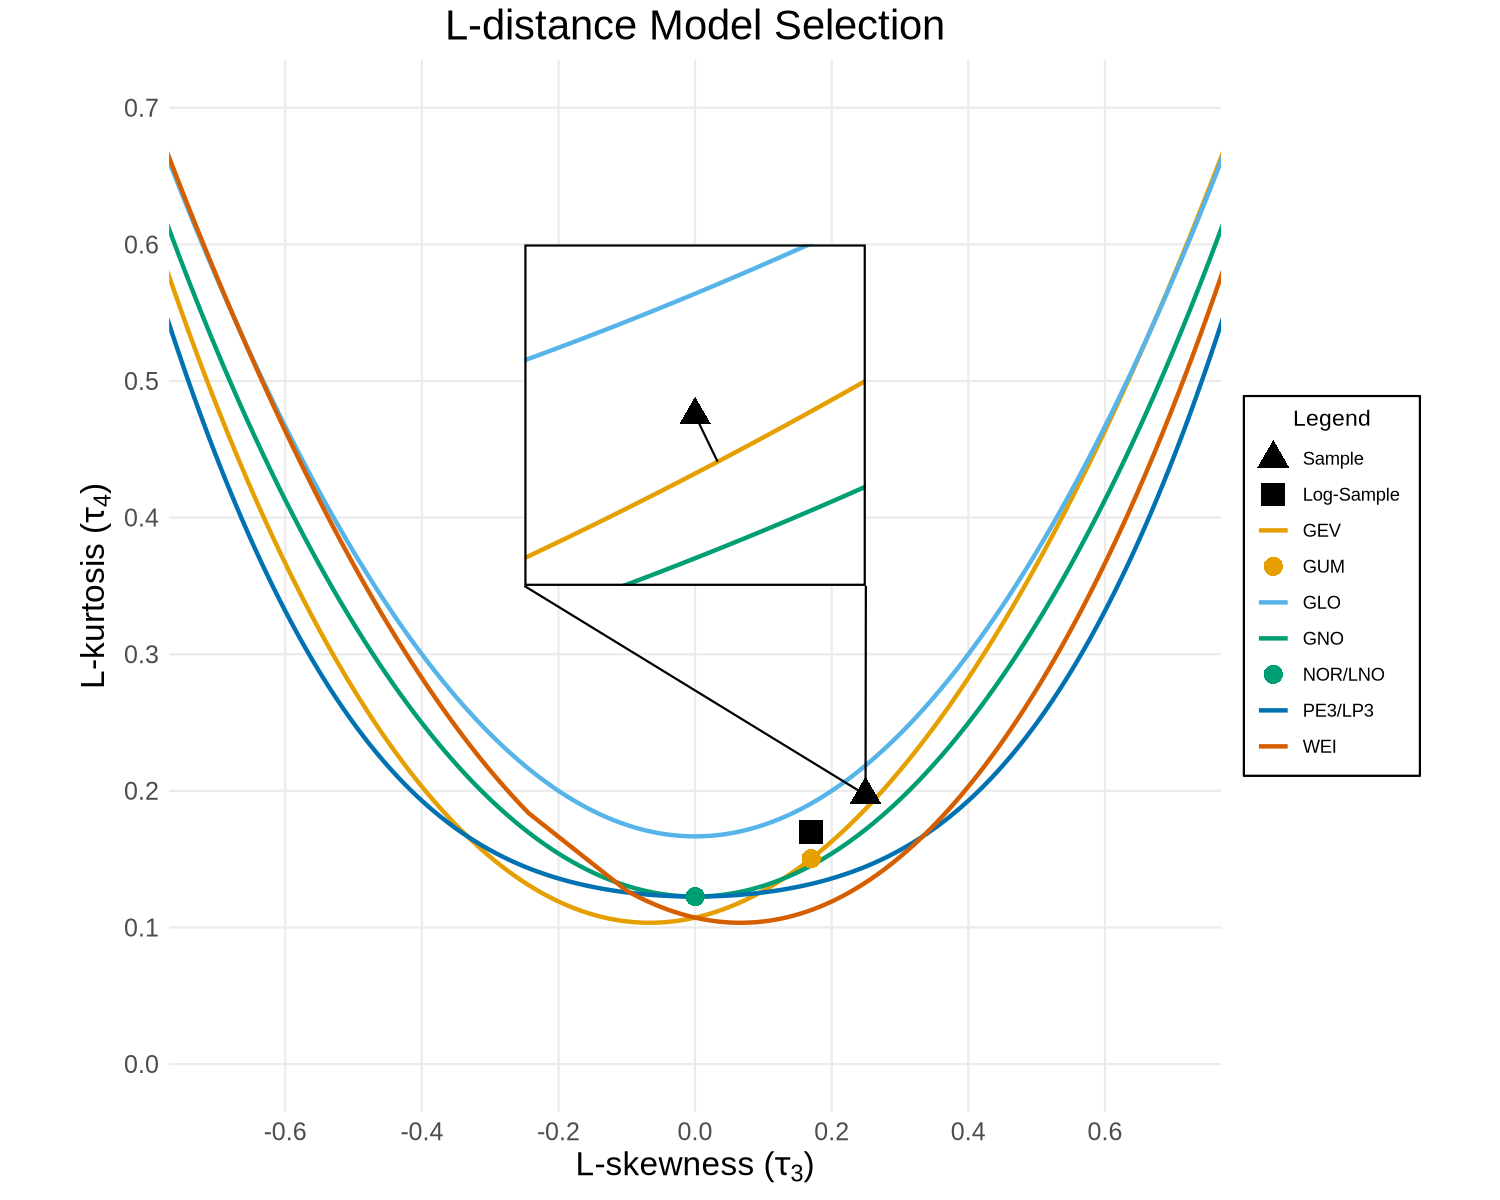

In [2]:
selection <- select_ldistance(df$max)

print(selection$recommendation)

plot_lmom_diagram(selection)

**Recommendation**: Use the generalized extreme value (GEV) distribution.

**Note**: For information about the other distributions, see the `selection$metrics` item.

You can find more information about the probability distributions supported by the framework [here](https://rileywheadon.github.io/ffa-docs/probability-distributions/).

## Parameter Estimation

The `ffaframework` package provides three methods for parameter estimation.
See [here](https://rileywheadon.github.io/ffa-docs/parameter-estimation/) for more information.

- `fit_lmom_*`: L-moments parameter estimation for each distribution.
- `fit_maximum_likelihood`: Maximum likelihood and generalized maximum likelihood.

In [3]:
params <- fit_lmom_gev(df$max)$params

print(params)

[1] 1600.219872  616.666030    0.120747


**Conclusion**: The GEV distribution with parameters `location = 1600`, `scale = 616`, and `shape = 0.12` will be used.

## Uncertainty Quantification

Once a probability distribution is fitted, return levels (design events) can be readily estimated.
However, point estimates alone can be misleading --it is more informative to report confidence intervals to reflect estimation uncertainty.
The `uncertainty_bootstrap` function performs uncertainty quantification using the parametric bootstrap method. It requires three arguments:

- `data`: A vector of annual maximum series data.
- `model`: A three-letter code for a probability distribution (ex. `"GEV"`).
- `method`: A parameter estimation method. Must be `"L-moments"`, `"MLE"`, or `"GMLE"`.

By default, return levels are computed 2-, 5-, 10-, 20-, 50-, and 100- year return periods. 

[1] 1831.312 2614.238 3194.788 3803.340 4673.826 5393.422


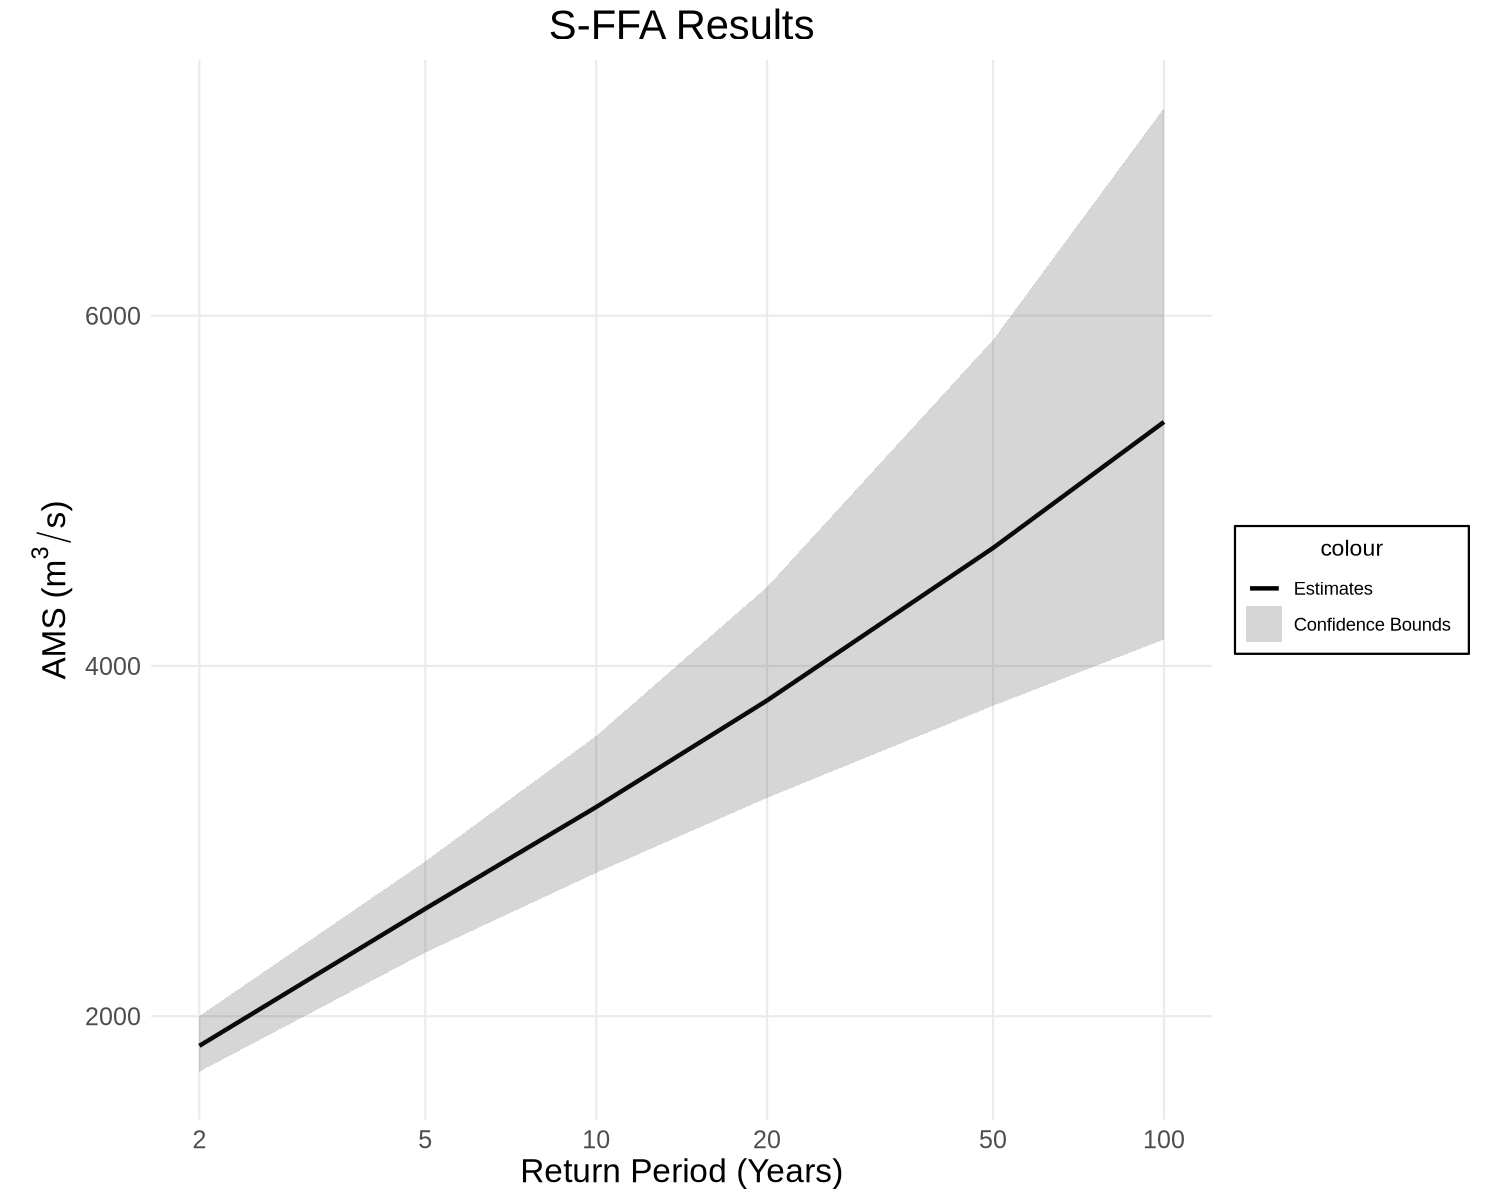

In [4]:
uncertainty <- uncertainty_bootstrap(df$max, "GEV", "L-moments")

print(uncertainty[[1]]$estimates)

plot_sffa(uncertainty)

**Example Conclusion**: Every 10 years, we can expect a flood of roughly $3{\small,}200\text{m}^3/\text{s}$ or greater.

## Model Assessment

Model performance is assessed using `model_diagnostics`, which reports a collection of assessment statistics about the flood frequency analysis.
`plot_model_diagnostics` compares the empirical plotting positions ("Observed Quantiles") and the predictions of the parametric model ("Model Quantiles"). 
The black line represents a perfect 1:1 correspondence between the model and the data.

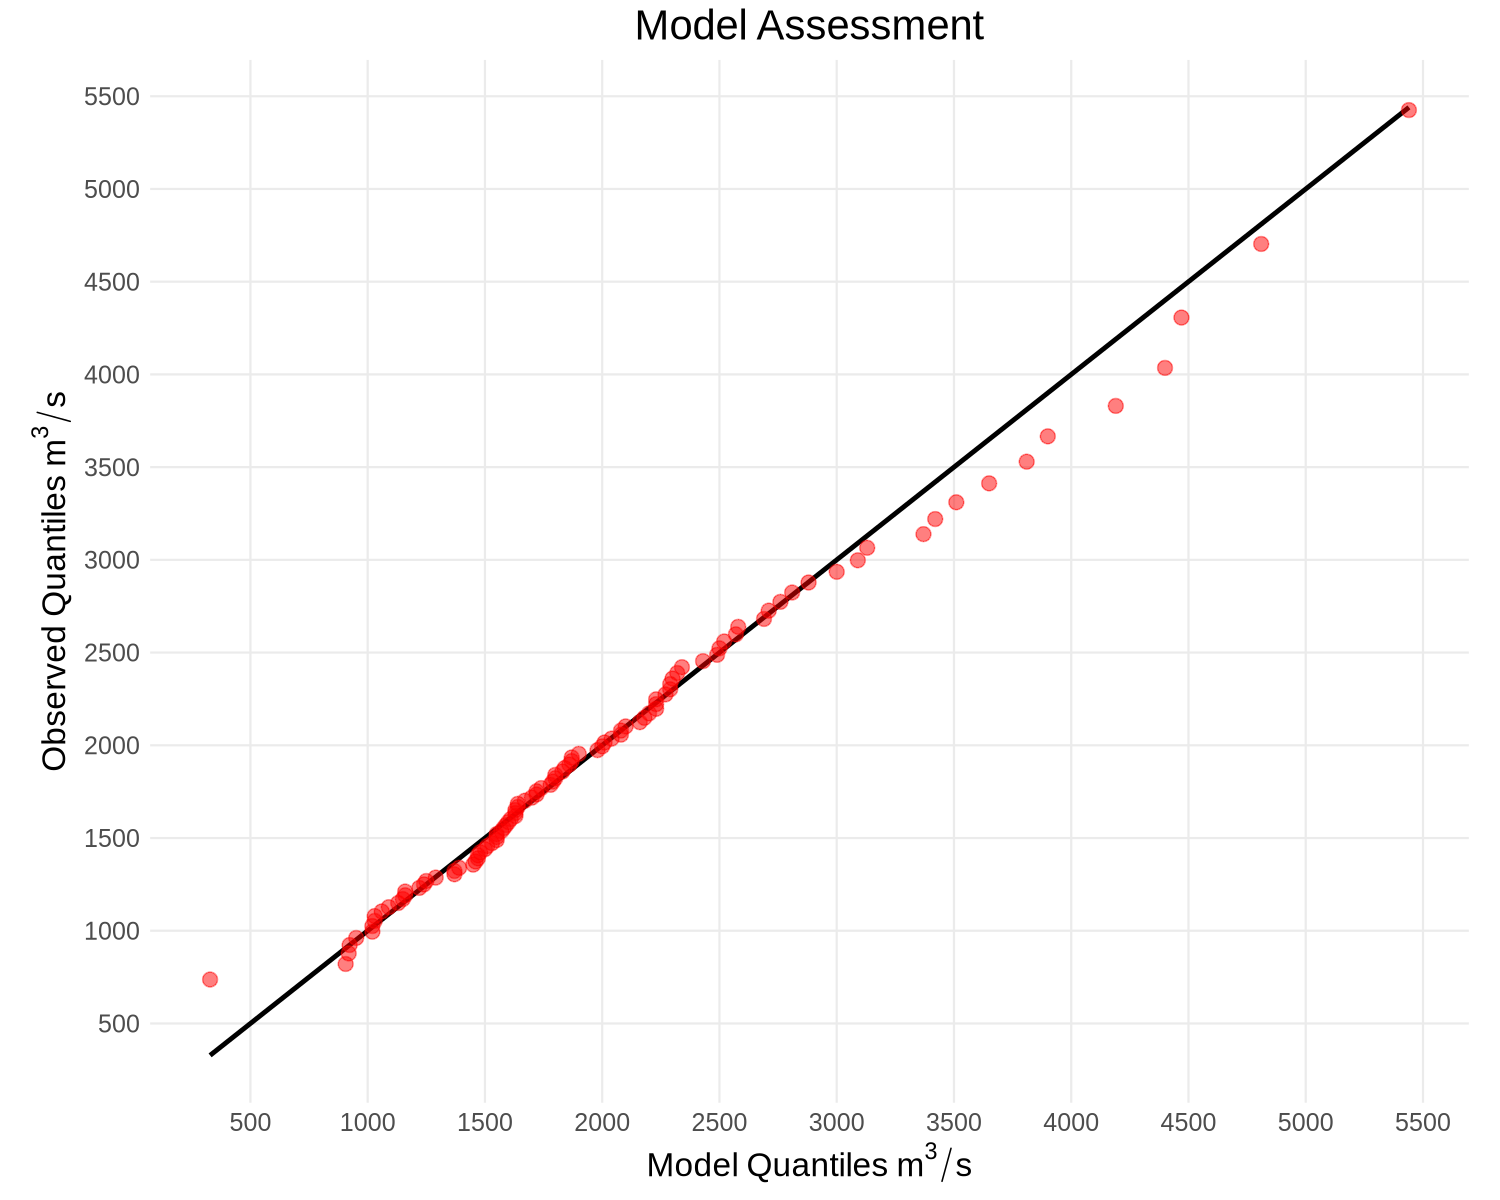

In [5]:
diagnostics <- model_diagnostics(df$max, "GEV", params, uncertainty)

plot_model_diagnostics(diagnostics)

**Conclusion**: The parametric model generally matches the plotting positions.
There is a small positive bias from $3{\small,}500\text{m}^3/\text{s}$ to $5{\small,}000\text{m}^3/\text{s}$.